# Traffic Sign Recogntion with TensorFlow Deep Learning,  
# Waleed Abdulla 22/05/2017

Última parte de la conferencia de Waleed Abdulla.

In [1]:
import os
import glob
import time
import skimage.data
import skimage.transform
#import sklearn.preprocessing
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers
import pandas as pd
import csv
import math
from IPython import display

# Allow image embeding in notebook
%matplotlib inline

D:\ANACONDA\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load Training and Test Data  
This is straightforward, the load() function traverses the dataset directories and loads the images and labels. Since this dataset is small, I load the whole thing into RAM to keep things simple.

In [2]:
def load_data(data_dir, width, height):
    directories = [d for d in os.listdir(data_dir) 
                 if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            labels.append(int(d))
            images.append(skimage.transform.resize(skimage.data.imread(f), (width, height)))
    
    labels=np.array(labels)
    images=np.array(images)
    
    return images, labels

In [3]:
train_data_dir = ".\\data\\Training"            
X_train_orig, Y_train_orig = load_data(train_data_dir,32,32)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
test_data_dir = ".\\data\\Testing" 
X_test_orig, Y_test_orig = load_data(test_data_dir,32,32)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [22]:
# TensorFlow doesn't have a native implementation of Leaky-ReLU
# that I know of. But it's simple enough to add it.
def lrelu(x):
    return tf.maximum(0.01*x,x)

## Model 4 Convolutional Layers - Accuracy 96%

In [94]:
class Model4():
    def conv(self, input, num_outputs, name=None):
        return layers.convolution2d(
            input, num_outputs=num_outputs, kernel_size=(5,5), stride=(1,1),
            padding='SAME', activation_fn=lrelu, normalizer_fn=layers.batch_norm
            )
    def pool(self, input):
        return layers.max_pool2d(input, kernel_size=(2,2),
                                stride=(2,2), padding='SAME')
    def __init__(self):
        #History of training state as tuples (step, loss, accuracy, training loss, time)
        self.train_log =[]
        self.train_time=[]
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global step counter
            self.global_step = tf.Variable(0, trainable=False, name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32, (None, 32,32,3), name='images')
            self.labels=tf.placeholder(tf.int32, (None), name='labels')
            #Block input shape [32,32,3], output shape [16,16,16]
            self.conv1 = self.conv(self.images,8)
            self.pool1=self.pool(self.conv1)
            #Block input shape: [16,16,16], output shape [8,8,32]
            self.conv2=self.conv(self.pool1,12)
            self.pool2=self.pool(self.conv2)
            #Block input shape: [8,8,32], ouutput shpae [4,4,64]
            self.conv3=self.conv(self.pool2,16)
            self.pool3=self.pool(self.conv3)
            #Fully connected layer
            self.flat=layers.flatten(self.pool3)
#            self.hl=layers_fully:connected(sefl.flat,200,lrelu)
            #self.shapeflat=self.flat.shape
            self.logits = layers.fully_connected(self.flat,62,lrelu)
            #Convert one hot vector to label index
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training OP
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                                .minimize(self.loss, global_step=self.global_step)
            #Initialization Op
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run initialization Op
            self.session.run(self.init)

In [95]:
m4 = Model4()

## <font color='red'>LOS OUTPUTS ESTÁN MAL CALCULADOS CREO <font color='red'> ## 

At this point, the network is starting to get too big to train comfortably on a CPU. This is a good time to switch to a copmuter with GPU support. I use P2 instances on EC2

Since things are getting serious, let's upgrade the training code as well. I'll make thes two improvemets.
+ 1. Track the training time of each step
+ 2. Visualize the accuracy and loss values in a graph

In [97]:
def train_graph(model, train_images, train_labels, val_images, Val_labels, train_count):
    t_start=time.time()
    #Training loop
    for i in range(1, train_count+1):
        ##??? improve picking batches
        #COGEMOS UN PEQUEÑO BATCH DE 100 IMAGENES RANDOM
        indexes = np.random.choice(np.arange(train_images.shape[0]),100,replace=False)
        batch_images=train_images[indexes]
        batch_labels=train_labels[indexes]
        #ENTRENAMOS ESTE BATCH CON NUESTRO MODELO
        _, loss = model.session.run([model.train, model.loss], {
            model.images:batch_images,
            model.labels:batch_labels,
            })
        # Evaluate
        if i % 50 == 0:
            evaluate_graph(model, batch_images, batch_labels, val_images, Val_labels, t_start)
    #Final evalution
    evaluate_graph(model, batch_images, batch_labels, val_images, Val_labels, t_start)
    #shape = model.session.run([model.shapeflat], {
    #        model.images:batch_images,
    #        model.labels:batch_labels,
    #        })
    #print(shape)

def evaluate_graph(model, train_images, train_labels, val_images, val_labels, training_time):
    #Run predicionts against a batch of the training set
    train_predicted, train_loss, step = model.session.run(
        [model.predicted_labels, model.loss, model.global_step],
        {model.images:train_images, model.labels:train_labels})
    
    #Run predictions against the full test set
    val_predicted, val_loss = model.session.run(
            [model.predicted_labels, model.loss],
            {model.images: val_images, model.labels:val_labels})
    
    #Calculate accuracy
    train_accuracy=np.sum(train_labels == train_predicted) / train_labels.shape[0]
    val_accuracy = np.sum(val_labels == val_predicted) / val_labels.shape[0]
    #Append to train log
    model.train_log.append((step, train_loss, train_accuracy, val_loss, val_accuracy, training_time))
    #Plot
    draw_graph(model.train_log)

def draw_graph(logs):
    #Expand log tuples to lists
    steps, train_losses, train_accuracies, val_losses, val_accuracies, times = zip(*logs)
    #Clear output
    display.clear_output(wait=True)
    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(8,6))
    #Graph 1: Accuracies
    ax1.set_title("Step: {}     Training Time:  {:.0f}  seconds\n"\
                  "Training Accuracy: {:.3f}    Validation Accuracy: {:.3f}"\
                  .format(steps[-1], times[-1], train_accuracies[-1], val_accuracies[-1]), 
                  fontsize=5)
    ax1.plot(steps, train_accuracies, label="Training Accuray")
    ax1.plot(steps, val_accuracies, label="Validation Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(fontsize=8, loc="lower right")
#    ax1.set_y1(0,1.1)
    #Graph 2 : Losses
    ax2.set_title("Training loss: {:.3f} Validation Loss: {:.3}"\
                 .format(train_losses[-1],val_losses[-1]),fontsize=5)
    ax2.set_yscale('log')
    ax2.plot(steps, train_losses, label="Training loss")
    ax2.plot(steps,val_losses, label="Validation Loss")
    ax2.set_ylabel("Loss")
    ax2.legend(fontsize=8, loc='lower left')
    ax2.set_xlabel("Steps")
    _ = plt.show()

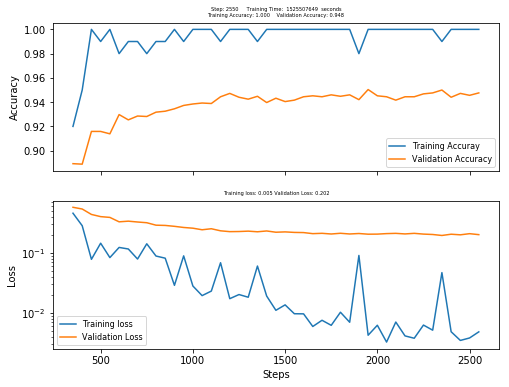

In [83]:
train_graph(m4, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 2000)

In [84]:
# Loop trough the graph and print the names and shapes of all trainable variables
with m4.graph.as_default():
    for v in tf.trainable_variables():
        print(v.name, v.get_shape())

Conv/weights:0 (5, 5, 3, 8)
Conv/BatchNorm/beta:0 (8,)
Conv_1/weights:0 (5, 5, 8, 12)
Conv_1/BatchNorm/beta:0 (12,)
Conv_2/weights:0 (5, 5, 12, 16)
Conv_2/BatchNorm/beta:0 (16,)
fully_connected/weights:0 (256, 62)
fully_connected/biases:0 (62,)


LA FULLY CONNNECTED TIENE 256,62 ESO QUIERE DECIR QUE EL INPUT ES DE 256 Y EL OUTPUT ES DE 62.  
El output nos cuadra, es igual al número de categorias.  
El input no parece que cuadre con lo que anota W.A. en el código.  
En el código pone que el output de la última pool layer es de 4x4x64=1024 y debería ser 256  
Lo que si podría ser es que el output fuera de 4x4x16 = 256  
Vamos a calcular una por una las capas para ver que esta pasando

Efectivamente parece que los outputs estaban mal calculados.  
+ IMÁGENES [32,32,3]
+ LAYER 1  
    - 8*CONV2D[5,5] S=1, P=0 --> {32-5+1=28} [28,28,8]  
    - POOL MAX[2,2] S=2, P=0 --> {(28-2)/2+1} [14,14,8]  
    - PESOS  [5,5,3,8] --> 600
+ LAYER 2  
    - 12*CONV2D[5,5] S=1, P=0 --> {14-5+1=9] [9,9,12]  
    - POOL MAX[2,2] S=2, P=0 --> {(9-2)/2+1] [5,5,12]
    - PESOS [5,5,8,12] --> 2400
+ LAYER 3  
    - 16*CONV2D[5,5] S=1, P=0 --> {5-5+1=1] [1,1,16]
    - POOL MAX[2,2] S=2, P=0 --> {(1-2)/2+1] [4,4,16]
    - PESOS [5,5,12,16] --> 4800
+ LAYER 4
    - FLATEN LAYER (3x3x16) [1,144]
    